# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

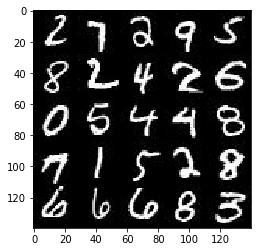

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

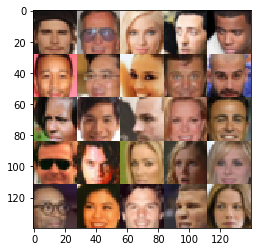

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0-rc0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
name: "assert_rank_2/Assert/Assert"
op: "Assert"
input: "assert_rank_2/Equal"
input: "assert_rank_2/Assert/Assert/data_0"
input: "assert_rank_2/Assert/Assert/data_1"
input: "assert_rank_2/rank"
input: "assert_rank_2/Assert/Assert/data_3"
input: "assert_rank_2/Shape"
attr {
  key: "T"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
      type: DT_INT32
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "summarize"
  value {
    i: 3
  }
}

If you want to mark it as used call its "mark_used()" method.
It was originally created here:
File "/home/titan/anaconda3/envs/tf-1.2.0/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
File "/home/titan/anaconda3/envs/tf-1.2.0/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
File "/home/titan/anaconda3/envs/tf-1.2.0/lib/pytho

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha = 0.2
        # 28x28x3
        conv1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(conv1, training=True)
        relu1 = tf.maximum(alpha * conv1, conv1)
#         relu1 = tf.nn.elu(conv1)
        # 14x14x128
        
        conv2 = tf.layers.conv2d(relu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * conv2, conv2)
#         relu2 = tf.nn.elu(bn2)
        # 14x14x256
        
        conv3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * conv3, conv3)
#         relu3 = tf.nn.elu(bn3)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        layer1 = tf.layers.dense(z, 7*7*512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
#         relu1 = tf.nn.elu(bn1)
        # 7x7x512
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
#         relu2 = tf.nn.elu(bn2)
        # 14x14x256
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
#         relu3 = tf.nn.elu(bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    label_smoothing = 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    inputs_real, inputs_z, inputs_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, inputs_learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, 
                                               inputs_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, 
                                               inputs_learning_rate: learning_rate})
                
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    g_train_loss = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.9998
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 1.3051
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.7201
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.7432
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.6782


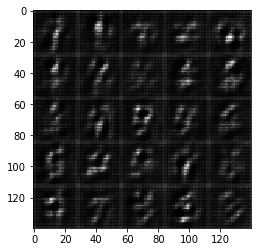

Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 1.5921... Generator Loss: 0.4116
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.6810
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 1.3394... Generator Loss: 0.7732


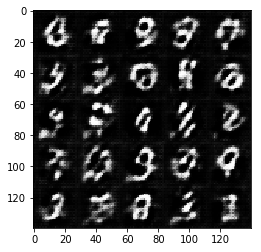

Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 1.0210
Epoch 1/2... Discriminator Loss: 1.2976... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.9069
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.6918


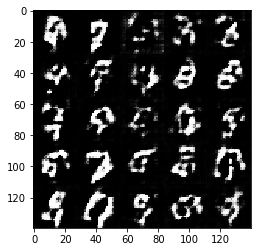

Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.8770
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.8914


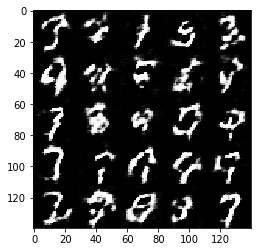

Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.6919
Epoch 1/2... Discriminator Loss: 1.2469... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 1.0208
Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.7601
Epoch 1/2... Discriminator Loss: 1.2024... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.8877
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.3140... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.8385


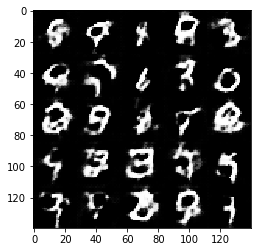

Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.8870
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.5358
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.7899
Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.7346


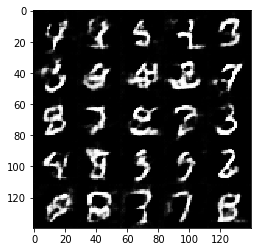

Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.9024
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.6731
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.5219
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.9137


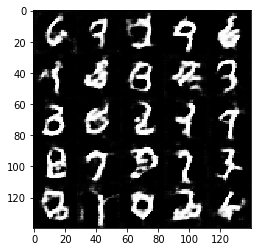

Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.9433
Epoch 1/2... Discriminator Loss: 1.2671... Generator Loss: 0.7852
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.0337
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.8469
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.9823
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.9413


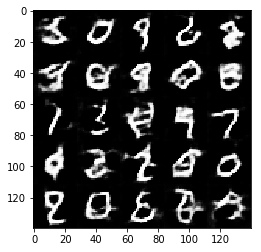

Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 1.2244
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.7946
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 1.2623
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 0.8671
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.9184
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.8724


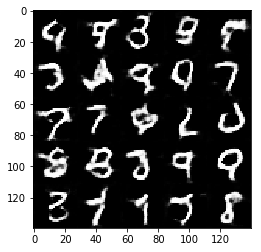

Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.8711
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.7229
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 1.1122
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.8315
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.7199
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.9200


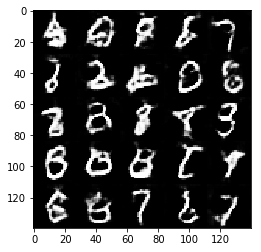

Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.9203
Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 1.2358
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.3519... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.8995


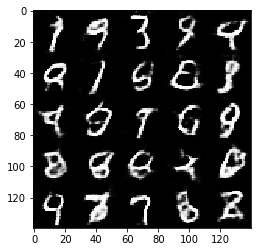

Epoch 2/2... Discriminator Loss: 1.3545... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.3257... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.6838
Epoch 2/2... Discriminator Loss: 1.3459... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.6006
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.9009
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 0.9405
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.9300


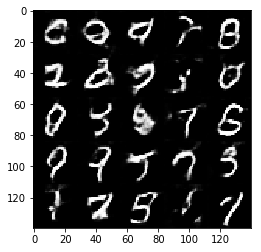

Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.3265... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 1.0324
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.9029


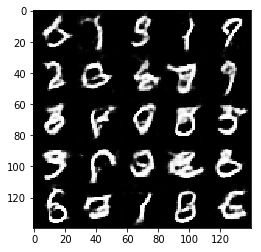

Epoch 2/2... Discriminator Loss: 1.2404... Generator Loss: 0.9405
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.3032... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.9369
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.9832
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 1.0714


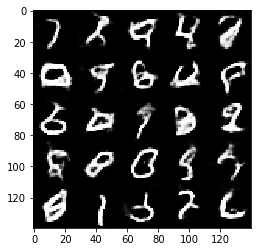

Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.9144
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.8664
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.6963
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.9195
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 1.2609... Generator Loss: 0.9311
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 1.0642
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.6482


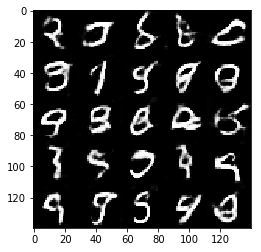

Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.2976... Generator Loss: 0.8215
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.7591
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 1.0387
Epoch 2/2... Discriminator Loss: 1.4594... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.8874
Epoch 2/2... Discriminator Loss: 1.1903... Generator Loss: 0.9589
Epoch 2/2... Discriminator Loss: 1.5079... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.8990
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.8215


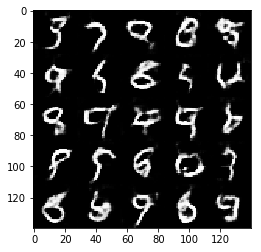

Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 0.6882
Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.7663
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.2602... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.2635... Generator Loss: 0.7769
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.9304
Epoch 2/2... Discriminator Loss: 1.2310... Generator Loss: 0.7862


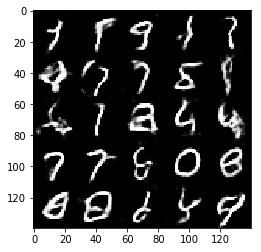

Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.8577
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.2364... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.7426
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 1.2807... Generator Loss: 0.7874
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.8971


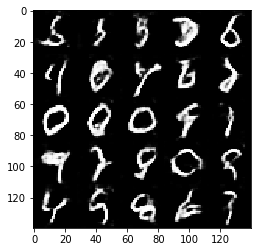

Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.9228


In [13]:
batch_size = 64
z_dim = 200
learning_rate = 0.00023
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.2258
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.9561


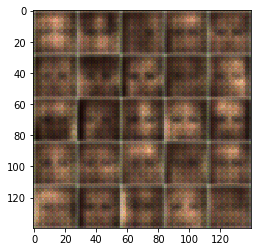

Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9187


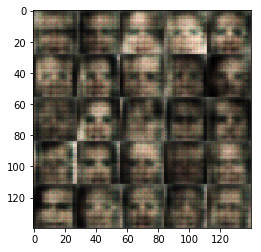

Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 0.6911... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 2.3785
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 3.5021
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 2.1076
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 2.2689


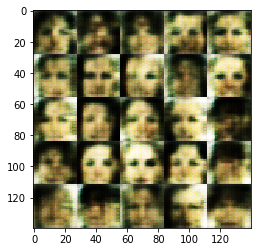

Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 2.0661
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.1039
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.8254
Epoch 1/1... Discriminator Loss: 0.8713... Generator Loss: 1.5089
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 2.9789
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.7882


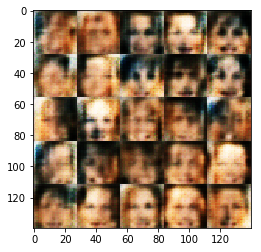

Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.8334


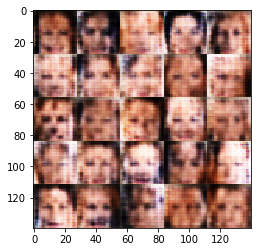

Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.7930
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.1071


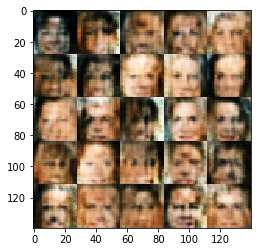

Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.5294
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.9356


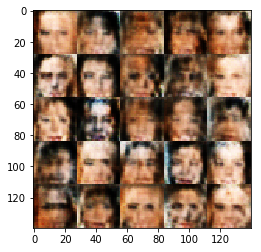

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8929


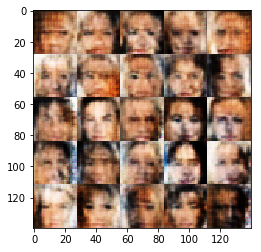

Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.4546


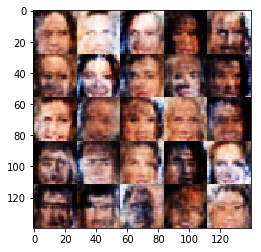

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.4090
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.0970
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.3309
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.0909


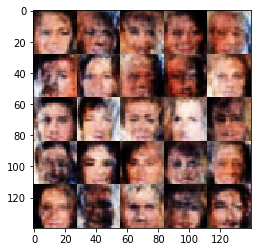

Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.8480
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.9878
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 1.3026
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 2.2513
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.5172


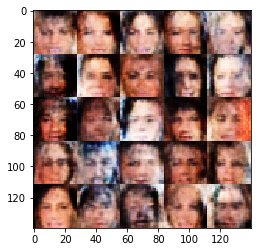

Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.8161
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 1.7011
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 2.1298
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.6150


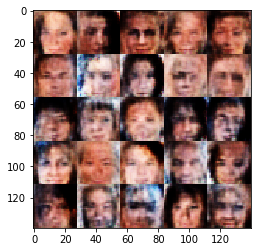

Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.2496
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.2368
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 2.2158
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.5389


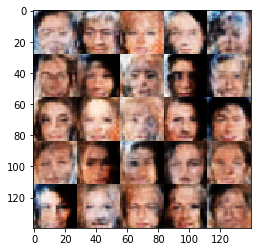

Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.4680
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 3.0081
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 2.9364
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.7875
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 2.1495
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.9042
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.4983
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.7512
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 2.5749


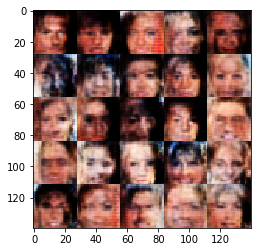

Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 2.7130
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 2.6031
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 0.8060... Generator Loss: 2.0363
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.7656
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 3.2902


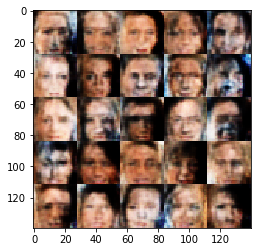

Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 2.8798
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 2.4474
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 2.3021
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.4138
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 3.6153
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.7163
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.6951
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.2188


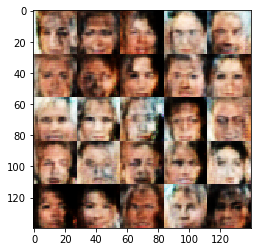

Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.7127
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 0.7058... Generator Loss: 2.7007
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.4150
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 2.1307


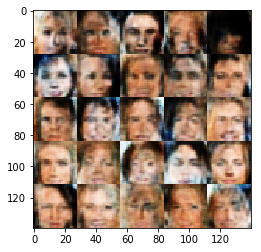

Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 2.3046
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 2.1114
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.4750
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.5971
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.7816
Epoch 1/1... Discriminator Loss: 0.5480... Generator Loss: 2.8462


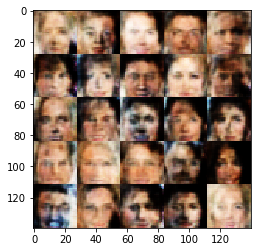

Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.9438
Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 2.3870
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 2.7271
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.7916
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 2.6809
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 2.1170


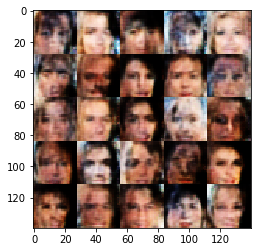

Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.5467
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 1.8500
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 2.6974
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 2.3211
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 2.3188


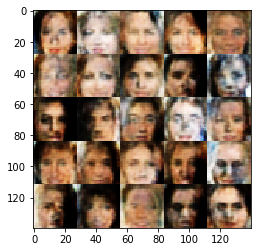

Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.7261
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 2.1972
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 2.3716
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.6597
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 1.6522
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.3077


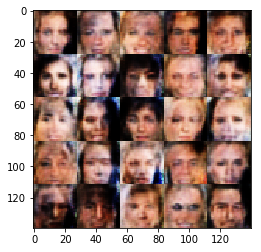

Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.5404
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 1.7834
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.9832


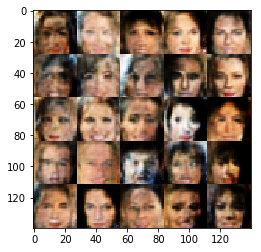

Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.9473
Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.4559
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 3.9494
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.8103


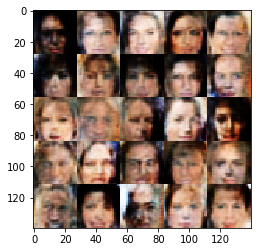

Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 2.5689
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.9912
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.7040
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 2.1036
Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.1464


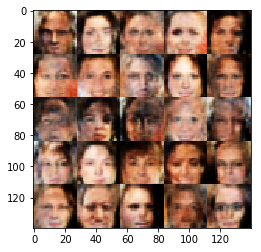

Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.6698
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.7716
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 2.9170
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 2.5082
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.6559
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.0282... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.2348


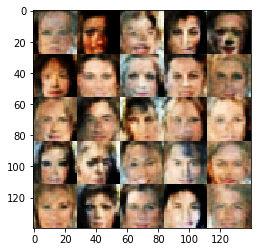

Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 1.4745
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 2.3169
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 2.0011
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.8380
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.7542
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 2.0578


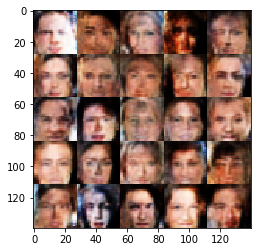

Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.3377
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 2.0148
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.7034
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 3.0417
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.4343
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 3.1285
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.6228


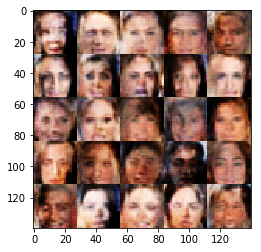

Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.5993
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.8198
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.6972
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.0009


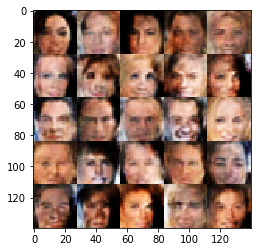

Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 4.0481
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.5350
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.5089
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.8660
Epoch 1/1... Discriminator Loss: 1.0333... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 2.0461
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.8351


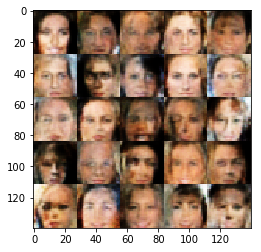

Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.6028
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 2.8984
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.8294
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.8653
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 1.9788
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 3.2783
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.3831


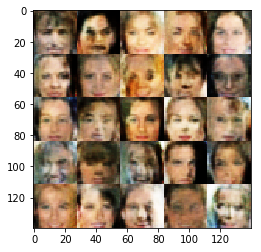

Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.3216
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 2.8155
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.7734
Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 2.2947
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.5869


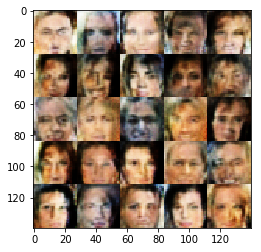

Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 2.0335
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.7158
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 2.3206
Epoch 1/1... Discriminator Loss: 0.8325... Generator Loss: 1.7924


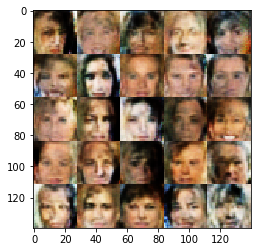

Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 1.4882
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.6747
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.8309
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.9015
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.3576


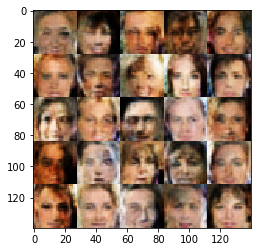

Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.1467
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.2734
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 2.0635
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 1.6165
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 2.0934
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.5518


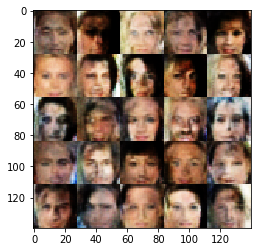

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.6726
Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.4984
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.6925
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.5375
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 2.0859


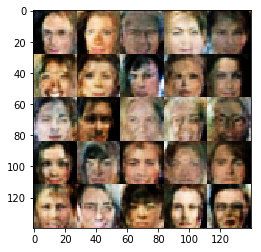

Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.1725
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.0785
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.9125... Generator Loss: 1.4547
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.2882
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.1540


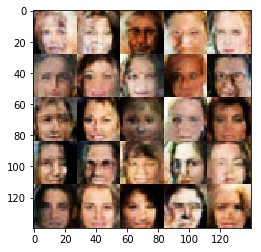

Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.9757
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.9646
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.6543
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 2.1353
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.6379


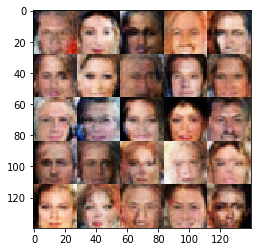

Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.6297
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.5037
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 2.2008
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.7241


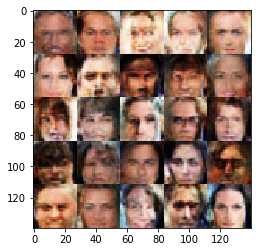

Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 2.1756
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.4855
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.1963
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 2.0031
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 2.0989
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.0605


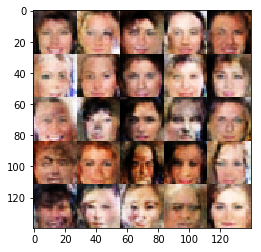

Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.5602
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 2.1945
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.8783
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.1508


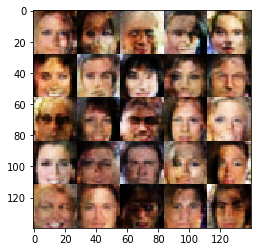

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.6578
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.7284
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 2.0075


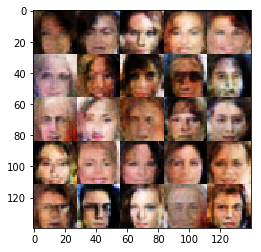

Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.7163
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.2128
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.4141


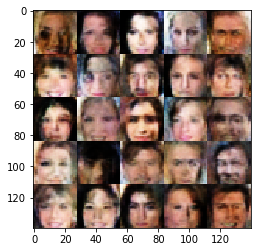

Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 2.5388
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.6147
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 1.4206


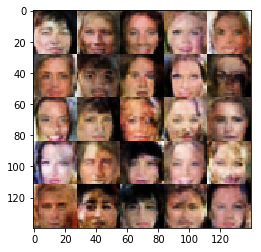

Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 2.1927
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.1430


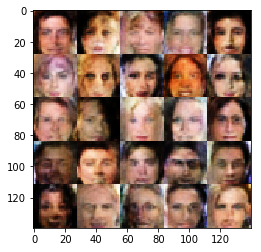

Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.6290
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.2440
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 3.1147
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.1395


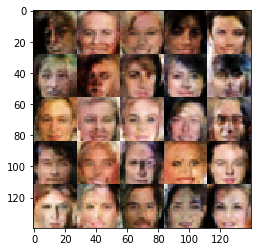

Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 2.5987
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.8679


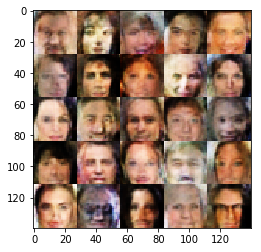

Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.0204


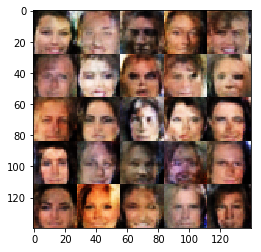

Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.1816
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 2.1594
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.7787


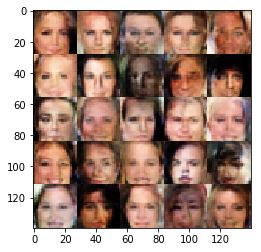

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 2.2296
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.3306


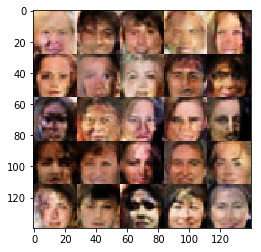

Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.4913
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 2.4046
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.1385


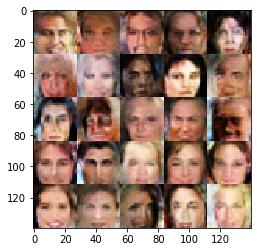

Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.3978
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.2702


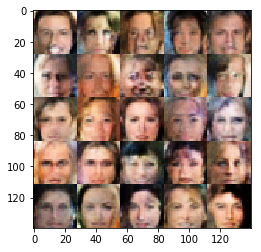

Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.2938
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.5486
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.7971


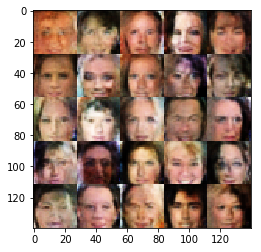

Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9763


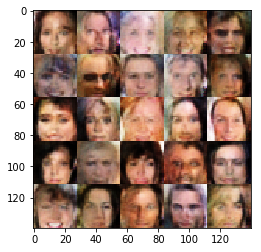

Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.3807
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.2307


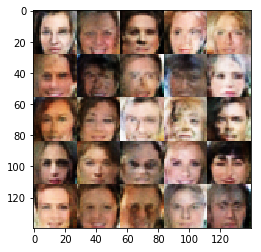

Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 2.1932
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.6306


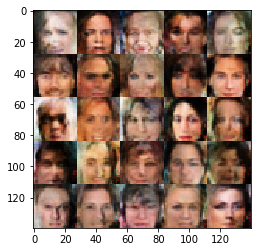

Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.8388
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.1819
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.1967
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0940


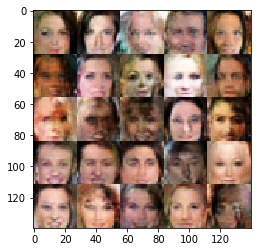

Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.3962
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 2.0273
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.4806
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.4543


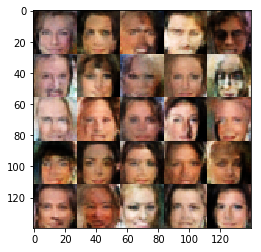

Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.4956
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 2.4183
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 3.4106
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.4064
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.9256


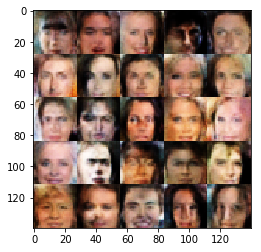

Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.4223
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.2190
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.7924
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.9317


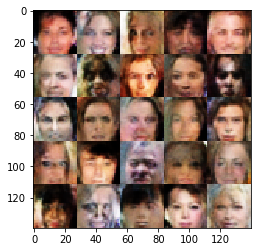

Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.6494
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8106


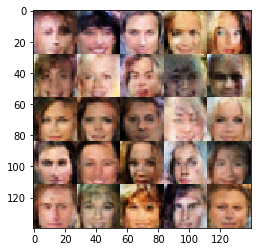

Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.5839
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.5539
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.3829


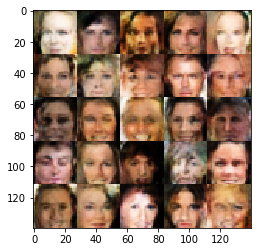

Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.5141
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.8495
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8783


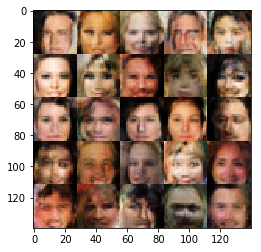

Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 1.9208
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 2.5144
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.0134


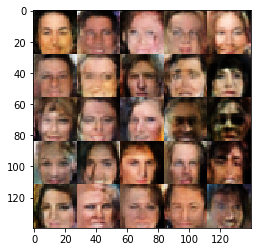

Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.9667


In [14]:
batch_size = 32
z_dim = 200
learning_rate = 0.00023
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Discuss

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.